In [1]:
import sqlite3

import pandas as pd

from paths import DB_FILE

popular_reviews = pd.read_sql("SELECT * FROM popular_reviews", sqlite3.connect(DB_FILE))
unpopular_reviews = pd.read_sql("SELECT * FROM unpopular_reviews", sqlite3.connect(DB_FILE))

## Reduce size of `unpopular_reviews` to size of `popular_reviews`
Also, combine both into a single dataframe afterward to create one-hot encoding

In [2]:
popular_reviews["is_popular"] = 1
unpopular_reviews["is_popular"] = 0

In [3]:
unpopular_reviews = unpopular_reviews.sample(n=popular_reviews.shape[0], random_state=42)

In [4]:
unpopular_reviews.shape, popular_reviews.shape

((261613, 12), (261613, 12))

In [5]:
df = pd.concat([popular_reviews, unpopular_reviews], ignore_index=True)

In [6]:
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df["character_count"] = df["text"].apply(lambda x: len(x))

## Visualize predictors

In [7]:
df.head()

,text,useful,funny,cool,review_age,review_stars,city,stars,review_count,fans,account_age,is_popular,word_count,character_count
0,I LOVE Weaver's Way and really disagree with s...,7,0,3,4795,5,Philadelphia,4.5,286.0,18.0,4937.0,1,270,1494
1,"I took the beginning class there, and I loved ...",15,0,2,3009,5,Tampa,5.0,32.0,4.0,3784.0,1,59,317
2,"Men's clubs is the tits, plain and simple. All...",3,4,3,2867,5,Philadelphia,4.5,5.0,0.0,3073.0,1,63,314
3,Came in after attending the Zurich Classic gol...,5,2,4,3179,4,New Orleans,4.5,1708.0,513.0,4382.0,1,92,485
4,This small little donut bakery is located in o...,14,6,9,2924,5,Hermitage,4.5,151.0,43.0,3882.0,1,155,932


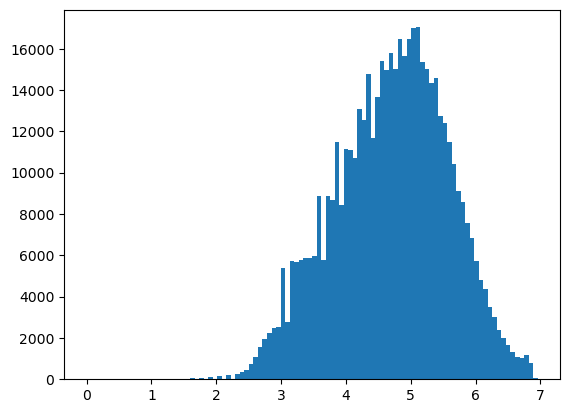

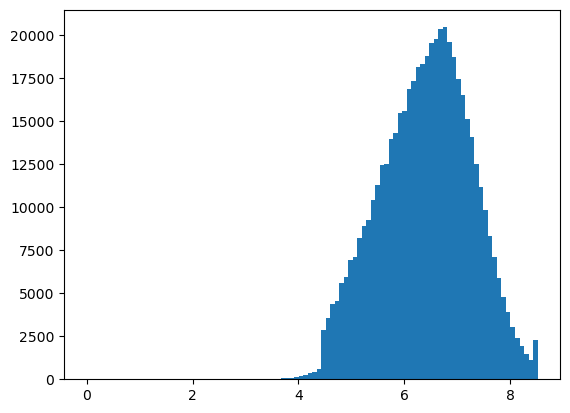

In [8]:
from matplotlib import pyplot as plt
import numpy as np

# histogram of review lengths
plt.hist(np.log(df["word_count"]), bins=100)
plt.show()
plt.hist(np.log(df["character_count"]), bins=100)
plt.show()

df["log_word_count"] = np.log(df["word_count"])
df["log_character_count"] = np.log(df["character_count"])

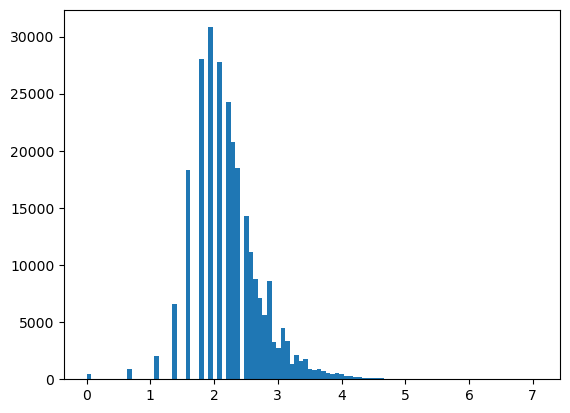

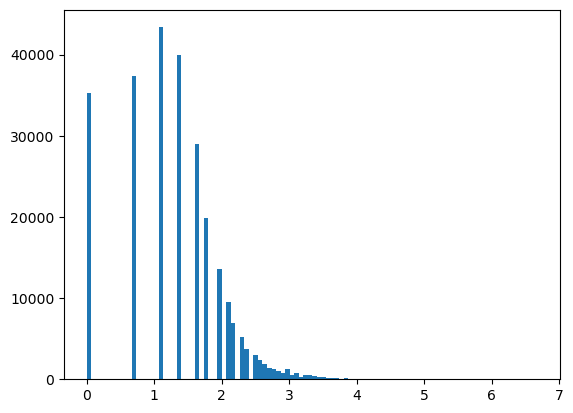

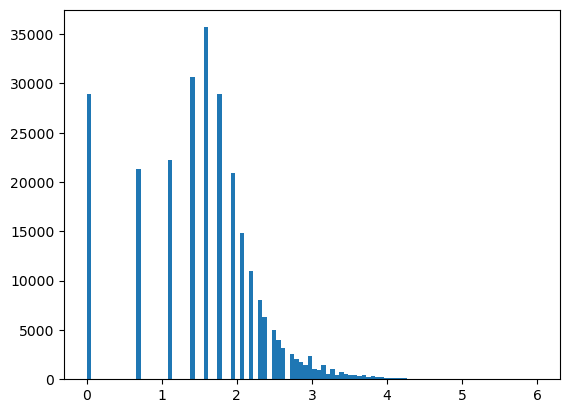

In [9]:
import numpy as np


plt.hist(np.log(popular_reviews["useful"] + 1), bins=100)
plt.show()
plt.hist(np.log(popular_reviews["funny"] + 1), bins=100)
plt.show()
plt.hist(np.log(popular_reviews["cool"] + 1), bins=100)
plt.show()

df["log_useful"] = np.log(df["useful"] + 1)
df["log_funny"] = np.log(df["funny"] + 1)
df["log_cool"] = np.log(df["cool"] + 1)

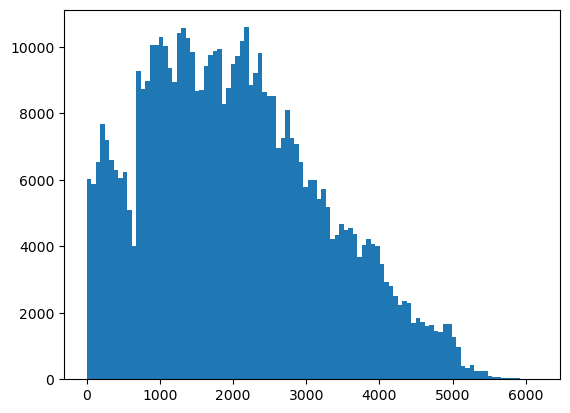

In [10]:
plt.hist(df["review_age"], bins=100)
plt.show()

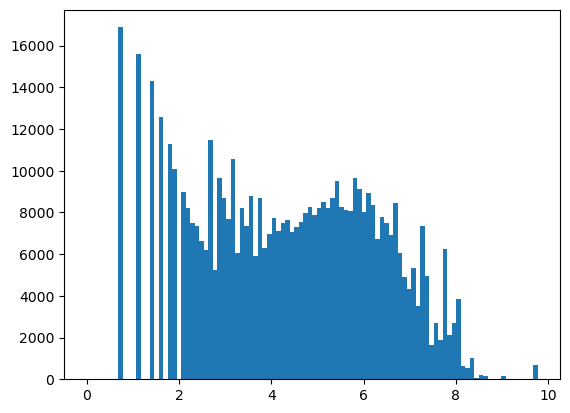

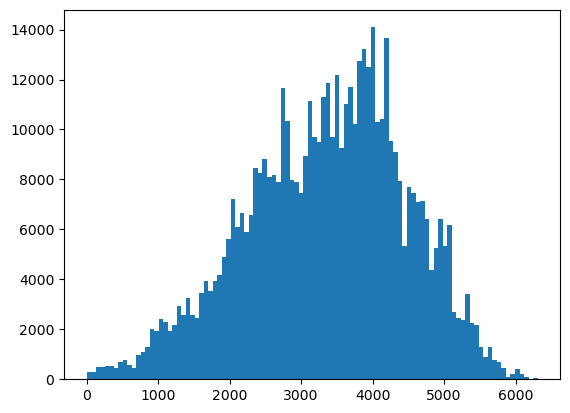

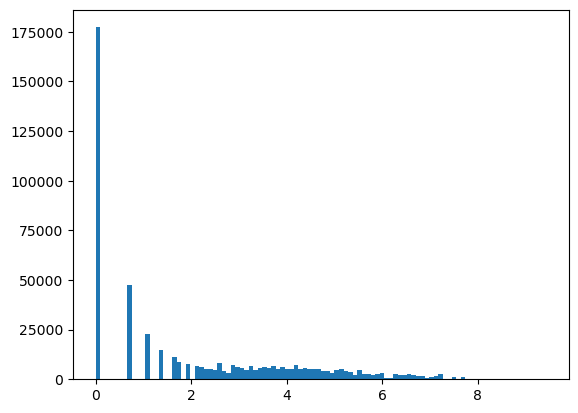

In [11]:
plt.hist(np.log(df["review_count"] + 1), bins=100)
plt.show()
plt.hist(df["account_age"], bins=100)
plt.show()
plt.hist(np.log(df["fans"] + 1), bins=100)
plt.show()

df["log_review_count"] = np.log(df["review_count"] + 1)
df["log_fans"] = np.log(df["fans"] + 1)

In [12]:
df.head()

,text,useful,funny,cool,review_age,review_stars,city,stars,review_count,fans,...,is_popular,word_count,character_count,log_word_count,log_character_count,log_useful,log_funny,log_cool,log_review_count,log_fans
0,I LOVE Weaver's Way and really disagree with s...,7,0,3,4795,5,Philadelphia,4.5,286.0,18.0,...,1,270,1494,5.598422,7.309212,2.079442,0.000000,1.386294,5.659482,2.944439
1,"I took the beginning class there, and I loved ...",15,0,2,3009,5,Tampa,5.0,32.0,4.0,...,1,59,317,4.077537,5.758902,2.772589,0.000000,1.098612,3.496508,1.609438
2,"Men's clubs is the tits, plain and simple. All...",3,4,3,2867,5,Philadelphia,4.5,5.0,0.0,...,1,63,314,4.143135,5.749393,1.386294,1.609438,1.386294,1.791759,0.000000
3,Came in after attending the Zurich Classic gol...,5,2,4,3179,4,New Orleans,4.5,1708.0,513.0,...,1,92,485,4.521789,6.184149,1.791759,1.098612,1.609438,7.443664,6.242223
4,This small little donut bakery is located in o...,14,6,9,2924,5,Hermitage,4.5,151.0,43.0,...,1,155,932,5.043425,6.837333,2.708050,1.945910,2.302585,5.023881,3.784190


## Create a one-hot encoding for `city` category

In [6]:
df = pd.get_dummies(df, columns=["city"])
df.shape

(523226, 1173)

## create sentence embeddings

In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [14]:
embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/16351 [00:00<?, ?it/s]

## create sentiment analysis

In [24]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

tqdm.pandas()


df_sentiment = df[["text"]].copy()

In [25]:
df_sentiment["tokens"] = df_sentiment["text"].progress_apply(lambda x: word_tokenize(x))

100%|██████████| 523226/523226 [07:55<00:00, 1100.86it/s] 


In [26]:
stopwords = stopwords.words('english')
df_sentiment["filtered_tokens"] = df_sentiment["tokens"].progress_apply(lambda x: [word for word in x if word not in stopwords])

100%|██████████| 523226/523226 [02:43<00:00, 3194.50it/s] 


In [27]:
lemmatizer = WordNetLemmatizer()
df_sentiment["lemmatized_tokens"] = df_sentiment["filtered_tokens"].progress_apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

100%|██████████| 523226/523226 [02:59<00:00, 2910.22it/s]


In [33]:
df_sentiment

,text,tokens,filtered_tokens,lemmatized_tokens,sentiment_scores,sentiment
0,I LOVE Weaver's Way and really disagree with s...,"[I, LOVE, Weaver, 's, Way, and, really, disagr...","[I, LOVE, Weaver, 's, Way, really, disagree, c...","[I, LOVE, Weaver, 's, Way, really, disagree, c...","{'neg': 0.077, 'neu': 0.735, 'pos': 0.188, 'co...",0.9665
1,"I took the beginning class there, and I loved ...","[I, took, the, beginning, class, there, ,, and...","[I, took, beginning, class, ,, I, loved, ., It...","[I, took, beginning, class, ,, I, loved, ., It...","{'neg': 0.039, 'neu': 0.553, 'pos': 0.408, 'co...",0.9586
2,"Men's clubs is the tits, plain and simple. All...","[Men, 's, clubs, is, the, tits, ,, plain, and,...","[Men, 's, clubs, tits, ,, plain, simple, ., Al...","[Men, 's, club, tit, ,, plain, simple, ., All,...","{'neg': 0.148, 'neu': 0.702, 'pos': 0.15, 'com...",0.0150
3,Came in after attending the Zurich Classic gol...,"[Came, in, after, attending, the, Zurich, Clas...","[Came, attending, Zurich, Classic, golf, tourn...","[Came, attending, Zurich, Classic, golf, tourn...","{'neg': 0.071, 'neu': 0.637, 'pos': 0.292, 'co...",0.9232
4,This small little donut bakery is located in o...,"[This, small, little, donut, bakery, is, locat...","[This, small, little, donut, bakery, located, ...","[This, small, little, donut, bakery, located, ...","{'neg': 0.055, 'neu': 0.709, 'pos': 0.235, 'co...",0.9685
...,...,...,...,...,...,...
523221,"Sadly, the food and service were subpar at Gas...","[Sadly, ,, the, food, and, service, were, subp...","[Sadly, ,, food, service, subpar, Gaslight, .,...","[Sadly, ,, food, service, subpar, Gaslight, .,...","{'neg': 0.077, 'neu': 0.798, 'pos': 0.125, 'co...",0.9069
523222,Recently went here for the first time. It's a ...,"[Recently, went, here, for, the, first, time, ...","[Recently, went, first, time, ., It, 's, cute,...","[Recently, went, first, time, ., It, 's, cute,...","{'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compou...",0.9357
523223,What a joke. $15 for some shrimp cocktail. $40...,"[What, a, joke, ., $, 15, for, some, shrimp, c...","[What, joke, ., $, 15, shrimp, cocktail, ., $,...","[What, joke, ., $, 15, shrimp, cocktail, ., $,...","{'neg': 0.081, 'neu': 0.777, 'pos': 0.142, 'co...",0.2263
523224,History + free air conditioning in olde city :...,"[History, +, free, air, conditioning, in, olde...","[History, +, free, air, conditioning, olde, ci...","[History, +, free, air, conditioning, olde, ci...","{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.9100


In [30]:
sid = SentimentIntensityAnalyzer()
df_sentiment["sentiment_scores"] = df_sentiment["lemmatized_tokens"].progress_apply(lambda x: sid.polarity_scores(' '.join(x)))
df_sentiment["sentiment"] = df_sentiment["sentiment_scores"].progress_apply(lambda x: x["compound"])

100%|██████████| 523226/523226 [00:00<00:00, 1753321.10it/s]


In [31]:
sentiment = df_sentiment["sentiment"].values.reshape(-1, 1)

## output everything

In [32]:
import pickle

from paths import OBJECTS_FOLDER


with open(OBJECTS_FOLDER / "embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

with open(OBJECTS_FOLDER / "sentiment.pkl", "wb") as f:
    pickle.dump(sentiment, f)

df.to_pickle(OBJECTS_FOLDER / "reviews.pkl")